In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\

In [2]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Filament

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    
    LEARNING_RATE = 0.001
    IMAGE_MIN_DIM = IMAGE_MAX_DIM = 256

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
      
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "fil")


     
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': 'name.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202,
        #   'file_attributes': {
        #            'width':256,
        #            'height':256}
        # }
        # We mostly care about the x and y coordinates of each region
        if subset == 'train':
            annotations1 = json.load(open('C:/Users/kenes/python_workplace/Mask_RCNN-master/dataset/train/training.json'))
        else:
            annotations1 = json.load(open('C:/Users/kenes/python_workplace/Mask_RCNN-master/dataset/val/validation.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"fil": 1,}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
dataset_train = CustomDataset()
dataset_train.load_custom('C:/Users/kenes/python_workplace/Mask_RCNN-master/dataset', "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:/Users/kenes/python_workplace/Mask_RCNN-master/dataset", "val")
dataset_val.prepare()

objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil',

objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil

objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fil', 'fi

In [11]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)

weights_path = COCO_MODEL_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

#model_path = model.find_last()
#print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)

In [12]:
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=35,
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\kenes\python_workplace\Mask_RCNN-master\logs\object20230725T1621\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kenes\miniconda3\envs\newenv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/35
10/10 [==============================] - 59s 6s/step - loss: 7.1299 - rpn_class_loss: 2.0608 - rpn_bbox_loss: 3.8164 - mrcnn_class_loss: 0.3215 - mrcnn_bbox_loss: 0.5301 - mrcnn_mask_loss: 0.4011 - val_loss: 4.6305 - val_rpn_class_loss: 0.5796 - val_rpn_bbox_loss: 2.7487 - val_mrcnn_class_loss: 0.2417 - val_mrcnn_bbox_loss: 0.7226 - val_mrcnn_mask_loss: 0.3379
Epoch 2/35
10/10 [==============================] - 51s 5s/step - loss: 4.5487 - rpn_class_loss: 0.7514 - rpn_bbox_loss: 2.8129 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.6207 - mrcnn_mask_loss: 0.2738 - val_loss: 4.3931 - val_rpn_class_loss: 0.4240 - val_rpn_bbox_loss: 2.6653 - val_mrcnn_class_loss: 0.1515 - val_mrcnn_bbox_loss: 0.7450 - val_mrcnn_mask_loss: 0.4073
Epoch 3/35
10/10 [==============================] - 50s 5s/step - loss: 4.3957 - rpn_class_loss: 0.3471 - rpn_bbox_loss: 2.5835 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.7589 - mrcnn_mask_loss: 0.5632 - val_loss: 4.3742 - val_rpn_class_loss: 0.42

Epoch 23/35
10/10 [==============================] - 53s 5s/step - loss: 3.8870 - rpn_class_loss: 0.2747 - rpn_bbox_loss: 2.4425 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.6349 - mrcnn_mask_loss: 0.3663 - val_loss: 4.1490 - val_rpn_class_loss: 0.3266 - val_rpn_bbox_loss: 2.5044 - val_mrcnn_class_loss: 0.2045 - val_mrcnn_bbox_loss: 0.7912 - val_mrcnn_mask_loss: 0.3222
Epoch 24/35
10/10 [==============================] - 53s 5s/step - loss: 3.8368 - rpn_class_loss: 0.2574 - rpn_bbox_loss: 2.4310 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.6741 - mrcnn_mask_loss: 0.3456 - val_loss: 4.1243 - val_rpn_class_loss: 0.3071 - val_rpn_bbox_loss: 2.5483 - val_mrcnn_class_loss: 0.1537 - val_mrcnn_bbox_loss: 0.7725 - val_mrcnn_mask_loss: 0.3426
Epoch 25/35
10/10 [==============================] - 51s 5s/step - loss: 3.7059 - rpn_class_loss: 0.2364 - rpn_bbox_loss: 2.5132 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.5479 - mrcnn_mask_loss: 0.3273 - val_loss: 4.2099 - val_rpn_class_loss: 0

In [27]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\kenes\python_workplace\Mask_RCNN-master\logs\object20230725T1621\mask_rcnn_object_0035.h5
Re-starting from epoch 35


8
original_image           shape: (256, 256, 3)         min:    0.00000  max:  198.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (22,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (22, 4)               min:   28.00000  max:  213.00000  int32
gt_mask                  shape: (256, 256, 22)        min:    0.00000  max:    1.00000  uint8


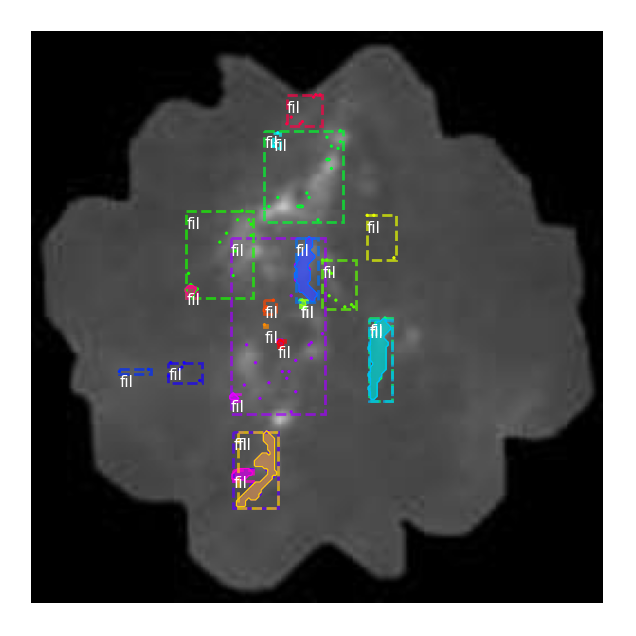

In [30]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(image_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))